In [ ]:
!pip install -U segmentation-models

     |████████████████████████████████| 51kB 7.7MB/s 


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras') 

Segmentation Models: using `keras` framework.


In [ ]:
sm.framework()

'tf.keras'

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

%cp /content/drive/MyDrive/diploma_notebooks/SliceDataGenerator.py .
%ls

Mounted at /content/drive/
drive/  sample_data/  SliceDataGenerator.py


In [ ]:
from SliceDataGenerator import DataGenerator
from tensorflow.keras import backend as K

pref_paths = ['/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData']
batch_size = 1

smooth=1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

H = 64
W = 64
h_crop=58
w_crop=186
data_gen = DataGenerator(pref_paths, batch_size, '/',H=H, W=W, h_crop=h_crop, w_crop=w_crop)

In [ ]:
from segmentation_models import Unet
from tensorflow.keras.layers import Input, Conv2D, Activation
from tensorflow.keras.models import Model


def create_model():
  base_model = Unet(backbone_name='resnet18',input_shape=(H,W,3), encoder_weights='imagenet')
  inp = Input(shape=(H,W,4)) # H, W, 620
  l1 = Conv2D(3, (1, 1))(inp) 
  out = base_model(l1)

  out = Conv2D(1,(1,1))(out)
  out = Activation('sigmoid')(out)

  model = Model(inp, out)
  model.compile(
      'Adam',
      loss=dice_coef_loss,
      metrics=[dice_coef],
  )
  return model

In [ ]:
model = create_model()

44924928/44920640 [==============================] - 1s 0us/step


Epoch 1/35
297/297 [==============================] - 1183s 4s/step - loss: -0.1667 - dice_coef: 0.1667 - val_loss: -0.1901 - val_dice_coef: 0.1901

Epoch 00001: saving model to /content/drive/MyDrive/Callbacks/callbacks14/weights.h5
Epoch 2/35
297/297 [==============================] - 193s 650ms/step - loss: -0.1719 - dice_coef: 0.1719 - val_loss: -0.1922 - val_dice_coef: 0.1922

Epoch 00002: saving model to /content/drive/MyDrive/Callbacks/callbacks14/weights.h5
Epoch 3/35
297/297 [==============================] - 231s 781ms/step - loss: -0.1767 - dice_coef: 0.1767 - val_loss: -0.1936 - val_dice_coef: 0.1936

Epoch 00003: saving model to /content/drive/MyDrive/Callbacks/callbacks14/weights.h5
Epoch 4/35
297/297 [==============================] - 236s 799ms/step - loss: -0.1811 - dice_coef: 0.1811 - val_loss: -0.1899 - val_dice_coef: 0.1899

Epoch 00004: saving model to /content/drive/MyDrive/Callbacks/callbacks14/weights.h5
Epoch 5/35
297/297 [==============================] - 200s

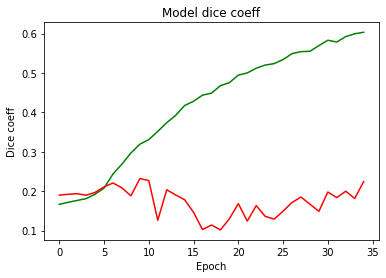

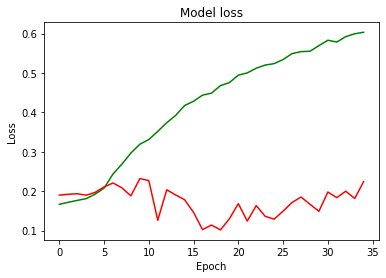

In [8]:
from tensorflow.keras import callbacks 
import matplotlib.pyplot as plt
checkpoint_path = '/content/drive/MyDrive/Callbacks/callbacks14/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(data_gen.train_X_slice_data_generator(), epochs=35,verbose=1,
                    callbacks=[cp_callback],validation_data = data_gen.test_X_slice_data_generator(),shuffle=True, steps_per_epoch=297, validation_steps=74)



plt.plot(history.history['dice_coef'], color='green')
plt.plot(history.history['val_dice_coef'], color='red')
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.show()


plt.plot(history.history['dice_coef'], color='green')
plt.plot(history.history['val_dice_coef'], color='red')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [9]:
loss, acc = model.evaluate(data_gen.test_X_slice_data_generator(),verbose=2, steps=74)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

74/74 - 46s - loss: -2.2439e-01 - dice_coef: 0.2244
Restored model, accuracy: 22.44%
